# Simulating Fake UKB Data

This produces a similar dataset in structure as the output from 00_data.py
This will from the basis to run the other scripts. 
However this may generate a dataset of roughly 2 GB. 

The main original script can be found at: 
- /ukb/scripts/00_data.py


In [1]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox
!pip3 install h5py

     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 614kB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=8559cb063870264faaa494d46f6b9060afc7d6f48147840783a6220fb1658fc9
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [2]:
# used to save data to google drive - from which we read data on demand - remove if google Colab is not used
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# set drive to fake data folder
dir_fakedata = '/content/drive/MyDrive/Colab Notebooks/ProbCox/replication/ukb/fakedata/'

In [4]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm
import h5py

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(4523)
torch.manual_seed(9845)

In [5]:
# Simulation Settings
# =======================================================================================================================
I = 50000 # Number of individuals
P_binary = 1118
P_continuous = 3
P = P_binary + P_continuous
theta = np.random.normal(0, 1, (20, 1))
print(theta)
theta = np.concatenate((theta[:17], np.zeros((1101, 1)), theta[-3:]))
scale = 35  # Scaling factor for Baseline Hazard


[[-1.18302056]
 [-0.88608555]
 [-0.61234235]
 [ 0.55986465]
 [-1.54122533]
 [ 1.16764028]
 [-0.69396521]
 [-0.49243977]
 [-0.83324629]
 [ 1.77323601]
 [ 0.09478817]
 [ 1.16418213]
 [ 0.78477761]
 [ 0.13095301]
 [-0.23373329]
 [-1.22177389]
 [-0.51322149]
 [ 0.12762651]
 [ 0.19943147]
 [-2.01894631]]



 Censorship:  0.92


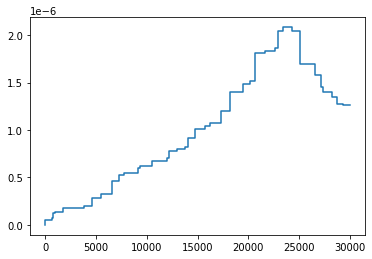

In [6]:

# Simulation 
# =======================================================================================================================

# Class for simulation
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# Sample baseline hazard - scale is set to define censorship/events
TVC.make_lambda0(scale=scale)

# gauge the number to desired level of censorship
print('\n Censorship: ', str(1 - (np.sum([torch.sum(TVC.sample()[0][:, -1]).numpy() for ii in (range(1000))])/1000)))

# Return the underlying shape of the baseline hazard and plot
t_l, ll = TVC.return_lambda0()
plt.step(t_l, ll)

In [7]:
total_events = 0
time = []
# Sample Data 
with h5py.File(dir_fakedata + 'fake_ukb.h5', 'w') as f:
  for _ in tqdm.tqdm(range(I)):
    surv, X = TVC.sample()
    f.create_group('_' + str(_))
    f['_' + str(_)].create_dataset("surv", data=surv.numpy())
    f['_' + str(_)].create_dataset("X", data=X.numpy())
    total_events += surv.numpy()[:, -1].sum()
    if surv.numpy()[-1, -1]==1:
        time.append(surv.numpy()[-1, 1])

print(total_events)

100%|██████████| 50000/50000 [18:28<00:00, 45.11it/s]

4163.0


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         3.,  0.,  0.,  0.,  0.,  2.,  3.,  1.,  4.,  2.,  2.,  1.,  0.,
         1.,  0.,  6.,  8.,  5.,  3.,  5.,  6.,  9.,  6.,  1.,  5.,  5.,
         4.,  4.,  5., 11.,  4.,  9., 12.,  9.,  7.,  8.,  9., 12., 10.,
         8., 10., 11.,  8., 15., 12., 14., 11., 13., 11.,  7., 12., 12.,
        14., 22.,  7., 19., 12., 12., 18., 18., 16., 13., 15.,  8., 11.,
         9., 13., 15., 13., 10., 25., 14., 13.,  6., 18., 20., 19., 21.,
        19., 15., 18., 20., 15., 14., 12., 18., 27., 23., 24., 22., 18.,
        21., 21., 24., 19., 21., 26., 22., 21., 18., 27., 25., 35., 28.,
        21., 26., 23., 21., 33., 30., 24., 24., 28., 13., 21., 26., 32.,
        26., 31., 26., 32., 20., 29., 25., 30., 24., 25., 24., 29., 31.,
        20., 27., 24., 25., 34., 27., 24., 23., 23., 34., 35., 37., 28.,
        27., 25., 33., 23., 31., 18., 22., 31., 24., 21., 26., 25., 26.,
        22., 28., 39., 29., 24., 30., 31., 20., 25.

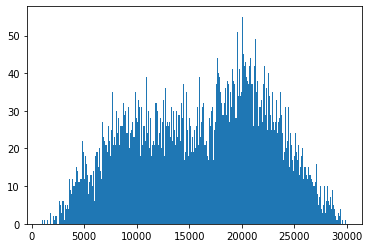

In [ ]:
plt.hist(time, bins=500)
plt.show()
plt.close()